## Demo Notebook to demonstrate process to run overturning calculation based on Argo float data

In [1]:
import pathlib
import sys

script_dir = pathlib.Path().parent.absolute()
parent_dir = script_dir.parents[0]
sys.path.append(str(parent_dir))

import xarray as xr
from labsea_project import readers, writers, plotters, tools, utilities
import subprocess
import numpy as np
import matplotlib.pyplot as plt

### 1 - Argo data loading and processing
First, we fetch Argo data within the Labradror Sea region form https://erddap.ifremer.fr year by year to avoid big files and crashes while loading, this takes some while. Next the data is merged and unnecessary data files are deleted

In [ ]:
# fetch argo data and save to 'data' directory
# this will take a while, so be patient
readers.fetch_argo_data_per_year()

2004: Saved to Argo_2004.nc
2005: Saved to Argo_2005.nc
2006: Saved to Argo_2006.nc
2007: Saved to Argo_2007.nc
2008: Saved to Argo_2008.nc
2009: Saved to Argo_2009.nc
2010: Saved to Argo_2010.nc
2011: Saved to Argo_2011.nc
2012: Saved to Argo_2012.nc
2013: Saved to Argo_2013.nc
2014: Saved to Argo_2014.nc
2015: Saved to Argo_2015.nc
2016: Saved to Argo_2016.nc
2017: Saved to Argo_2017.nc
2018: Saved to Argo_2018.nc


c:\Users\schul\OneDrive\Dokumente\Arbeit\Uni HH 2025\labsea-project\labsea-env\Lib\site-packages\gsw\stability.py:86: RuntimeWarning: divide by zero encountered in divide
  N2 = ((g_local**2) / (specvol_mid * db_to_pa * dp))


2019: Saved to Argo_2019.nc
2020: Saved to Argo_2020.nc
2021: Saved to Argo_2021.nc
2022: Saved to Argo_2022.nc
2023: Saved to Argo_2023.nc
Finished downloading available yearly data.


In [ ]:

# Merge fetched agro data into one dataset along the profile dimension and delete individual yearly files to save space
data_dir = parent_dir / 'data'
files = sorted(data_dir.glob('ArgoFetched_*.nc'))
ds = xr.open_mfdataset(files, combine='nested', concat_dim='N_PROF', engine="netcdf4")
ds.to_netcdf(data_dir / 'LabSea_Argo_2004_2023.nc')

print("All files successfully merged and saved.")

for file in data_dir.glob('ArgoFetched_*.nc'):
    file.unlink()   

print("All individual yearly files have been deleted.")

Now we will process the data to select only profiles in range of 75km of the AR7W line
and save the result to a new file, delte the original file to save space.
The script will generate two nc files, one includes only profiles within 1000dbar isobars in the region, the other also includes some profiles on the shelf. It will aslo generate a plot of the profiles in the region to validate the script ran correctly.

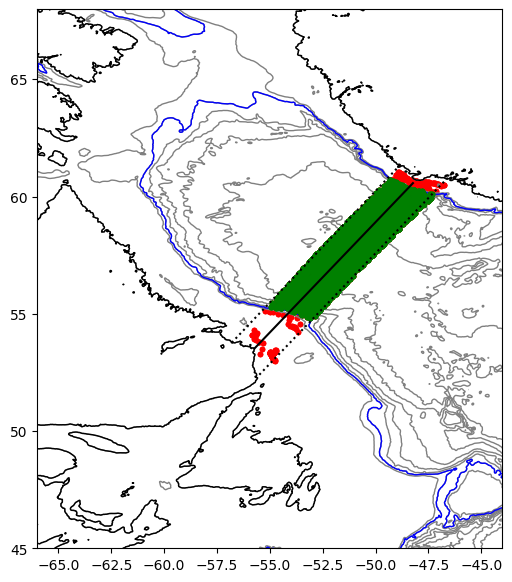

Argo data processing complete. Datasets saved.


In [13]:
script_path = f'{parent_dir}/scripts/argo_data_processing.py'
%run "{script_path}"

### 2 - Derive gridded composite sections

Now we calculate composite sections defining years and months argo data is selected for. For the demo, the months May, June and July are choosen for the decade between 2004 and 2013. First, masks are created for the specified cases and then weighted means are calculated with specified options, e.g the section start and end, the grid spacing and the parameter 'omega' which gives the width of the gaussian curve used for weighting in km. Gridded composites of sepcific volume anomaly, sigma0, SA and CT are saved automatically.

In [ ]:
# This function will select profiles and save a mask based on the specified season, and years,
# which is then used further to derive gridded sections for the selected case.

filename =  parent_dir / "data/argo_profiles_75kmAR7W_2004_to_2023_1000dB_isobars_filtered.nc"
case_str = '0413_mayjunjul'                                          # case string to identify the case
season = [5,6,7]                                                     # indicate months to select for the case
years = [2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013] # indicate years to select for the case
tools.select_profiles_and_save_masks(filename, case_str, season, years)

Mask saved to c:\Users\schul\OneDrive\Dokumente\Arbeit\Uni HH 2025\labsea-project\data\profile masks\mask_0413_mayjunjul.nc


In [ ]:
# Argo
case = '0413_mayjunjul'
file_case = '2004_to_2023_1000db_isobars'

script_path = parent_dir / "scripts" / "calc_weighted_mean.py"
filename = parent_dir / "data" / f"argo_profiles_75kmAR7W_{file_case}_filtered.nc"
mask_profiles_file =  parent_dir / "data/profile masks" / f"mask_{case}.nc" # set to 'empty' if no mask should be used

# Optional arguments
spacing_z = 25
spacing_x = 10
omega = 30.0
xstart = 200
xend = 860

# make sure the output directory exists
output_dir = parent_dir / "data" / "weighted data"
output_dir.mkdir(parents=True, exist_ok=True)

output_file = parent_dir / "data/weighted data" / f"weighted_data_{file_case}_{case}_omega{int(omega)}_xstart{str(xstart)}_xend{xend}.npy"
python_executable = sys.executable

# Run the script
process_w = subprocess.Popen(
    [
        python_executable, str(script_path),
        str(filename),
        str(mask_profiles_file),
        str(output_file),
        "--spacing_z", str(spacing_z),
        "--spacing_x", str(spacing_x),
        "--omega", str(omega),
        "--xstart", str(xstart),
        "--xend", str(xend),
        "--argo"
    ],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True,
    encoding='utf-8'  
)

# Display output in real-time
for line in process_w.stdout:
    print(line, end="") 
    
# Display errors in real-time
for line in process_w.stderr:
    print(line, end="")

argo data is treated
c:\Users\schul\OneDrive\Dokumente\Arbeit\Uni HH 2025\labsea-project\data\argo_profiles_75kmAR7W_2004_to_2023_1000db_isobars_filtered.nc
